In [1]:
from pathlib import Path
from warnings import simplefilter

simplefilter(action="ignore")

PROJECT_DIR = Path()
DATA_DIR = PROJECT_DIR / "dataset"

In [45]:
w

import matplotlib.pyplot as plt
import numpy as np
import pmdarima as pm
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.tsa.stattools as tst
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)

INF_SUB = -1e-6

plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(12, 4))
plt.rc("axes", titleweight="bold")
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

###################
# Model Selection #
###################


def store_level_auto_arima(
    store_df, families=None, horizon=30, trace=False, plot=False
):
    if not isinstance(families, list):
        families = store_df.columns

    results = pd.DataFrame(
        index=["model", "order", "seasonal_order", "aic", "mae", "mse", "mape"],
        columns=families,
    )

    for fam in families:
        print(f"\n{fam}\n")
        train = log_transform(store_df[fam].iloc[:-horizon])
        val = store_df[fam].iloc[-horizon:]
        model = pm.auto_arima(
            train,
            start_p=1,
            start_q=1,
            D=1,
            m=7,
            trend="ct",
            trace=trace,
        )
        print(f"AIC: {model.aic()}")
        fore = inverse_log_transform(model.predict(horizon))

        results.loc["model", fam] = model
        results.loc["order", fam] = model.order
        results.loc["seasonal_order", fam] = model.seasonal_order
        results.loc["aic", fam] = model.aic()
        results.loc["mae", fam] = mean_absolute_error(val, fore)
        results.loc["mse", fam] = mean_squared_error(val, fore)
        results.loc["mape", fam] = mean_absolute_percentage_error(val, fore)

        if plot:
            ax = (
                store_df[fam]
                .iloc[:-horizon]
                .rename("Train")
                .plot(**plot_params, figsize=(12, 5))
            )
            val.rename("Validation").plot(ax=ax, color="blue")
            fore.rename("Forecast").plot(ax=ax, color="red")
            ax.set_title(fam)
            ax.legend()

    return results


# def cross_validate(series, horizon=30, train_steps=183):
#   train_start = series.index[0]


#########
# Plots #
#########


def plot_weekly(series):
    weekly = pd.DataFrame(index=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    for time, grp in series.groupby(pd.Grouper(freq="W")):
        if len(grp.values) == 6:
            weekly[time.week] = np.insert(grp.values, 0, 0)
        elif len(grp.values) == 7:
            weekly[time.week] = grp.values

    weekly.plot(legend=False)


def store_plots(store_nbr, store_df, lags=20):
    nrows = store_df.shape[1]
    fig, axes = plt.subplots(nrows, 3, figsize=(25, 5 * nrows))
    fig.suptitle(f"Run Sequence, ACF and PACF Plots for Store No. {store_nbr}")

    for (fam, ser), ax in zip(store_df.items(), axes):
        ax[0].set_title(fam)
        ser.plot(ax=ax[0], **plot_params)

        ax[1].set_xlim(left=-1, right=lags + 2)
        ax[2].set_xlim(left=-1, right=lags + 2)
        sm.tsa.graphics.plot_acf(ser, ax=ax[1], lags=lags, zero=False)
        if not (ser.eq(0) | ser.eq(INF_SUB)).all():
            sm.tsa.graphics.plot_pacf(ser, ax=ax[2], lags=lags, zero=False)
        else:
            ax[2].set_ylim(bottom=-1, top=1)
            ax[2].set_title("Partial Autocorrelation")


#############
# Selection #
#############


def cross_validation_sarima(
    series,
    order,
    seasonal_order,
    trend,
    lookback=90,
    horizon=30,
    k=6,
    seed=42,
    plot=False,
):
    rng = np.random.default_rng(seed=seed)
    val_idx = rng.integers(low=lookback, high=len(series) - horizon, size=k)
    metrics = pd.DataFrame([], columns=["mae", "mse", "mape"])
    fig, axes = plt.subplots(k, figsize=(12, 4 * k))

    for i, ax in zip(val_idx, axes):
        train = series.iloc[0:i].rename("Train")
        val = series.iloc[i : i + horizon].rename("Validation")
        sar = tsa.statespace.SARIMAX(
            log_transform(train),
            order=order,
            seasonal_order=seasonal_order,
            trend=trend,
        ).fit()
        y_pred = inverse_log_transform(sar.predict()).rename("Prediction")
        y_fore = inverse_log_transform(
            sar.predict(start=val.index[0], end=val.index[-1])
        ).rename("Forecast")
        metrics.loc[f"{val.index[0]}_{val.index[-1]}"] = pd.Series(
            {
                "mae": mean_absolute_error(val, y_fore),
                "mse": mean_squared_error(val, y_fore),
                "mape": mean_absolute_percentage_error(val, y_fore),
            },
        )

        if plot:
            train.plot(ax=ax, **plot_params)
            val.plot(ax=ax, style=".-", color="blue", alpha=0.5)
            y_pred.plot(ax=ax, color="cyan")
            y_fore.plot(ax=ax, color="magenta")
            ax.legend()

    return metrics


def grid_search_sarima(
    series, orders, seasonal_orders, trends, lookback=90, horizon=30, k=6, seed=42
):
    metrics = pd.DataFrame([], columns=["mae", "mse", "mape"])
    for trend in trends:
        for order in orders:
            for sorder in seasonal_orders:
                metrics[f"{trend}_{order}_{sorder}"] = cross_validation_sarima(
                    series, order, sorder, trend, lookback=lookback, horizon=horizon, k=k, seed=seed
                ).mean()

    return metrics


#################
# Preprocessing #
#################


def store_level_preprocess(
    store_df,
    apply_log=False,
    d=None,
    D=None,
    m=None,
    use_adf=False,
):
    if use_adf:
        non_stat_cols = adf_non_stationary_families(store_level_adfs(store_df))
    else:
        non_stat_cols = list(store_df.columns)

    processed = store_df.copy()
    for fam, ser in processed.items():
        if apply_log:
            ser = log_transform(ser)

        if isinstance(d, int) and ser.name in non_stat_cols:
            for _ in range(d):
                ser = ser.diff()

        if isinstance(D, int) and isinstance(m, int):
            for _ in range(D):
                ser = ser.diff(m)

        processed[fam] = ser.fillna(0.0)

    return processed


def store_level_adfs(store_df):
    adfs = pd.DataFrame(
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Observations Used",
            "Critical Value (1%)",
            "Critical Value (5%)",
            "Critical Value (10%)",
        ],
        columns=store_df.columns,
    )

    for i, fam in enumerate(store_df):
        adf = tst.adfuller(store_df[fam])
        adfs.iloc[0:4, i] = adf[0:4]
        for thresh, crit in adf[4].items():
            adfs.loc[f"Critical Value ({thresh})", fam] = crit

    return adfs


def adf_non_stationary_families(adfs):
    truths = adfs.loc["Test Statistic"].ge(adfs.loc["Critical Value (1%)"])

    return list(truths[truths].index)


def log_transform(ser):
    ser = np.log(ser)
    # Replace `-inf` values with INF_SUB.
    ser[ser == -np.inf] = INF_SUB

    return ser


def inverse_log_transform(ser):
    # Restore the `-inf` values for exponentiation.
    ser[ser == INF_SUB] = -np.inf

    return np.exp(ser)

In [9]:
import pandas as pd

store_sales = (
    pd.read_csv(
        DATA_DIR / "train.csv", parse_dates=["date"], dtype={"sales": "float32"}
    )
    .set_index(["date"])
    .to_period(freq="D")
    .set_index(["store_nbr", "family"], append=True)["sales"]
    .unstack()
    .unstack()
)

# Fill in values for missing dates.
missing_idx = set(
    pd.date_range(
        store_sales.index[0].to_timestamp(), store_sales.index[-1].to_timestamp()
    ).to_period()
) - set(store_sales.index.get_level_values(level=0).unique())
for idx in missing_idx:
    store_sales.loc[idx] = 0.0

store_sales = store_sales.stack().sort_index(level=0)
store_sales

family                AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  \
date       store_nbr                                                    
2013-01-01 1                 0.0        0.0     0.0        0.0    0.0   
           2                 0.0        0.0     0.0        0.0    0.0   
           3                 0.0        0.0     0.0        0.0    0.0   
           4                 0.0        0.0     0.0        0.0    0.0   
           5                 0.0        0.0     0.0        0.0    0.0   
...                          ...        ...     ...        ...    ...   
2017-08-15 50               11.0        0.0    16.0     3661.0    0.0   
           51               11.0        0.0     2.0     3860.0    0.0   
           52                2.0        0.0     4.0     3744.0    0.0   
           53                9.0        0.0     7.0     1646.0    0.0   
           54                8.0        0.0     0.0     4332.0    0.0   

family                BREAD/BAKERY  CELEBRATION  CLEANING   DAIRY        DELI  \
date       store_nbr                                                            
2013-01-01 1              0.000000          0.0       0.0     0.0    0.000000   
           2              0.000000          0.0       0.0     0.0    0.000000   
           3              0.000000          0.0       0.0     0.0    0.000000   
           4              0.000000          0.0       0.0     0.0    0.000000   
           5              0.000000          0.0       0.0     0.0    0.000000   
...                            ...          ...       ...     ...         ...   
2017-08-15 50           466.130005         45.0    1322.0  1018.0  429.618988   
           51           704.801025         16.0    1357.0  1377.0  217.886002   
           52           756.481018         15.0    1412.0  1053.0  298.610992   
           53           380.199005          4.0     706.0   431.0  186.867996   
           54           304.000000          4.0    1415.0   261.0  222.026001   

family                ...  MAGAZINES       MEATS  PERSONAL CARE  PET SUPPLIES  \
date       store_nbr  ...                                                       
2013-01-01 1          ...        0.0    0.000000            0.0           0.0   
           2          ...        0.0    0.000000            0.0           0.0   
           3          ...        0.0    0.000000            0.0           0.0   
           4          ...        0.0    0.000000            0.0           0.0   
           5          ...        0.0    0.000000            0.0           0.0   
...                   ...        ...         ...            ...           ...   
2017-08-15 50         ...       13.0  425.802002          396.0           9.0   
           51         ...       13.0  567.848999          234.0          15.0   
           52         ...       19.0  435.828003          278.0           9.0   
           53         ...        5.0  185.798004          153.0           5.0   
           54         ...        2.0   57.841999          169.0           0.0   

family                PLAYERS AND ELECTRONICS     POULTRY  PREPARED FOODS  \
date       store_nbr                                                        
2013-01-01 1                              0.0    0.000000        0.000000   
           2                              0.0    0.000000        0.000000   
           3                              0.0    0.000000        0.000000   
           4                              0.0    0.000000        0.000000   
           5                              0.0    0.000000        0.000000   
...                                       ...         ...             ...   
2017-08-15 50                            22.0  356.510010       73.851997   
           51                            25.0  686.940979       91.975998   
           52                            20.0  397.339996      104.417999   
           53                             5.0  148.014999       37.820000   
           54     

In [10]:
store_level_sales = []
for group, frame in store_sales.groupby(level=1):
    store_level_sales.append((group, frame.reset_index(level=1, drop=True)))

store_level_sales = dict(store_level_sales)

In [41]:
STORE_NO = 9
FAMILY = "POULTRY"
y = store_level_sales[STORE_NO][FAMILY]

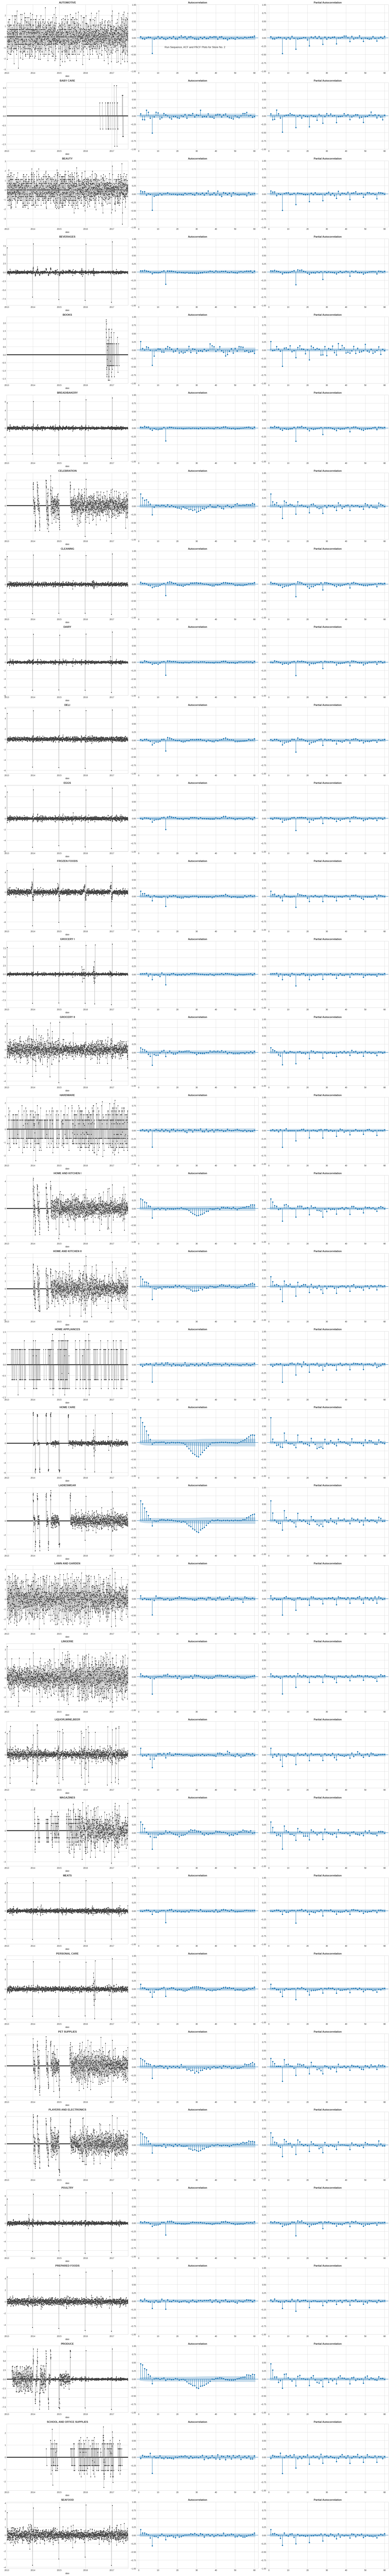

In [22]:
df = store_level_preprocess(
    store_level_sales[STORE_NO],
    apply_log=True,
    d=0,
    D=1,
    m=7,
    use_adf=True,
)
store_plots(STORE_NO, df, lags=60)

In [ ]:
# results_s1 = store_level_auto_arima(
#     store_level_sales[2], families=["AUTOMOTIVE"], horizon=30, plot=True
# )
# results_s1

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.83263D-01    |proj g|=  3.23939D+00

At iterate    5    f=  6.88299D-01    |proj g|=  1.13318D-01

At iterate   10    f=  6.79416D-01    |proj g|=  7.53290D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     19      1     0     0   4.105D-05   6.794D-01
  F =  0.67941599487165949     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.32969D-01    |proj g|=  1.63636D-01

At iterate    5    f=  8.30887D-01    |proj g|=  5.10801D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   1.817D-06   8.309D-01
  F =  0.83088657164901158     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.45511D-01    |proj g|=  2.60601D-01

At iterate    5    f=  8.40708D-01    |proj g|=  1.75992D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     10      1     0     0   1.039D-05   8.407D-01
  F =  0.84070771652925425     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49441D-01    |proj g|=  2.63022D-01

At iterate    5    f=  8.44532D-01    |proj g|=  3.84497D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   3.183D-05   8.445D-01
  F =  0.84453179958271096     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  7.31819D-01    |proj g|=  3.53295D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      9      1     0     0   3.533D-05   7.318D-01
  F =  0.73181852362042144     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


mae            mse          mape
2013-08-18_2013-09-16   71.666663    8542.260268  1.662569e-01
2016-07-27_2016-08-25   69.616174    8834.243299  1.567068e-01
2016-01-22_2016-02-20  101.736239   18038.065933  2.214062e-01
2015-02-18_2015-03-19  130.373544   32553.672578  2.186735e-01
2015-02-08_2015-03-09  141.631751   31140.892515  2.950391e-01
2016-12-07_2017-01-05  268.462944  196752.837851  2.281959e+17

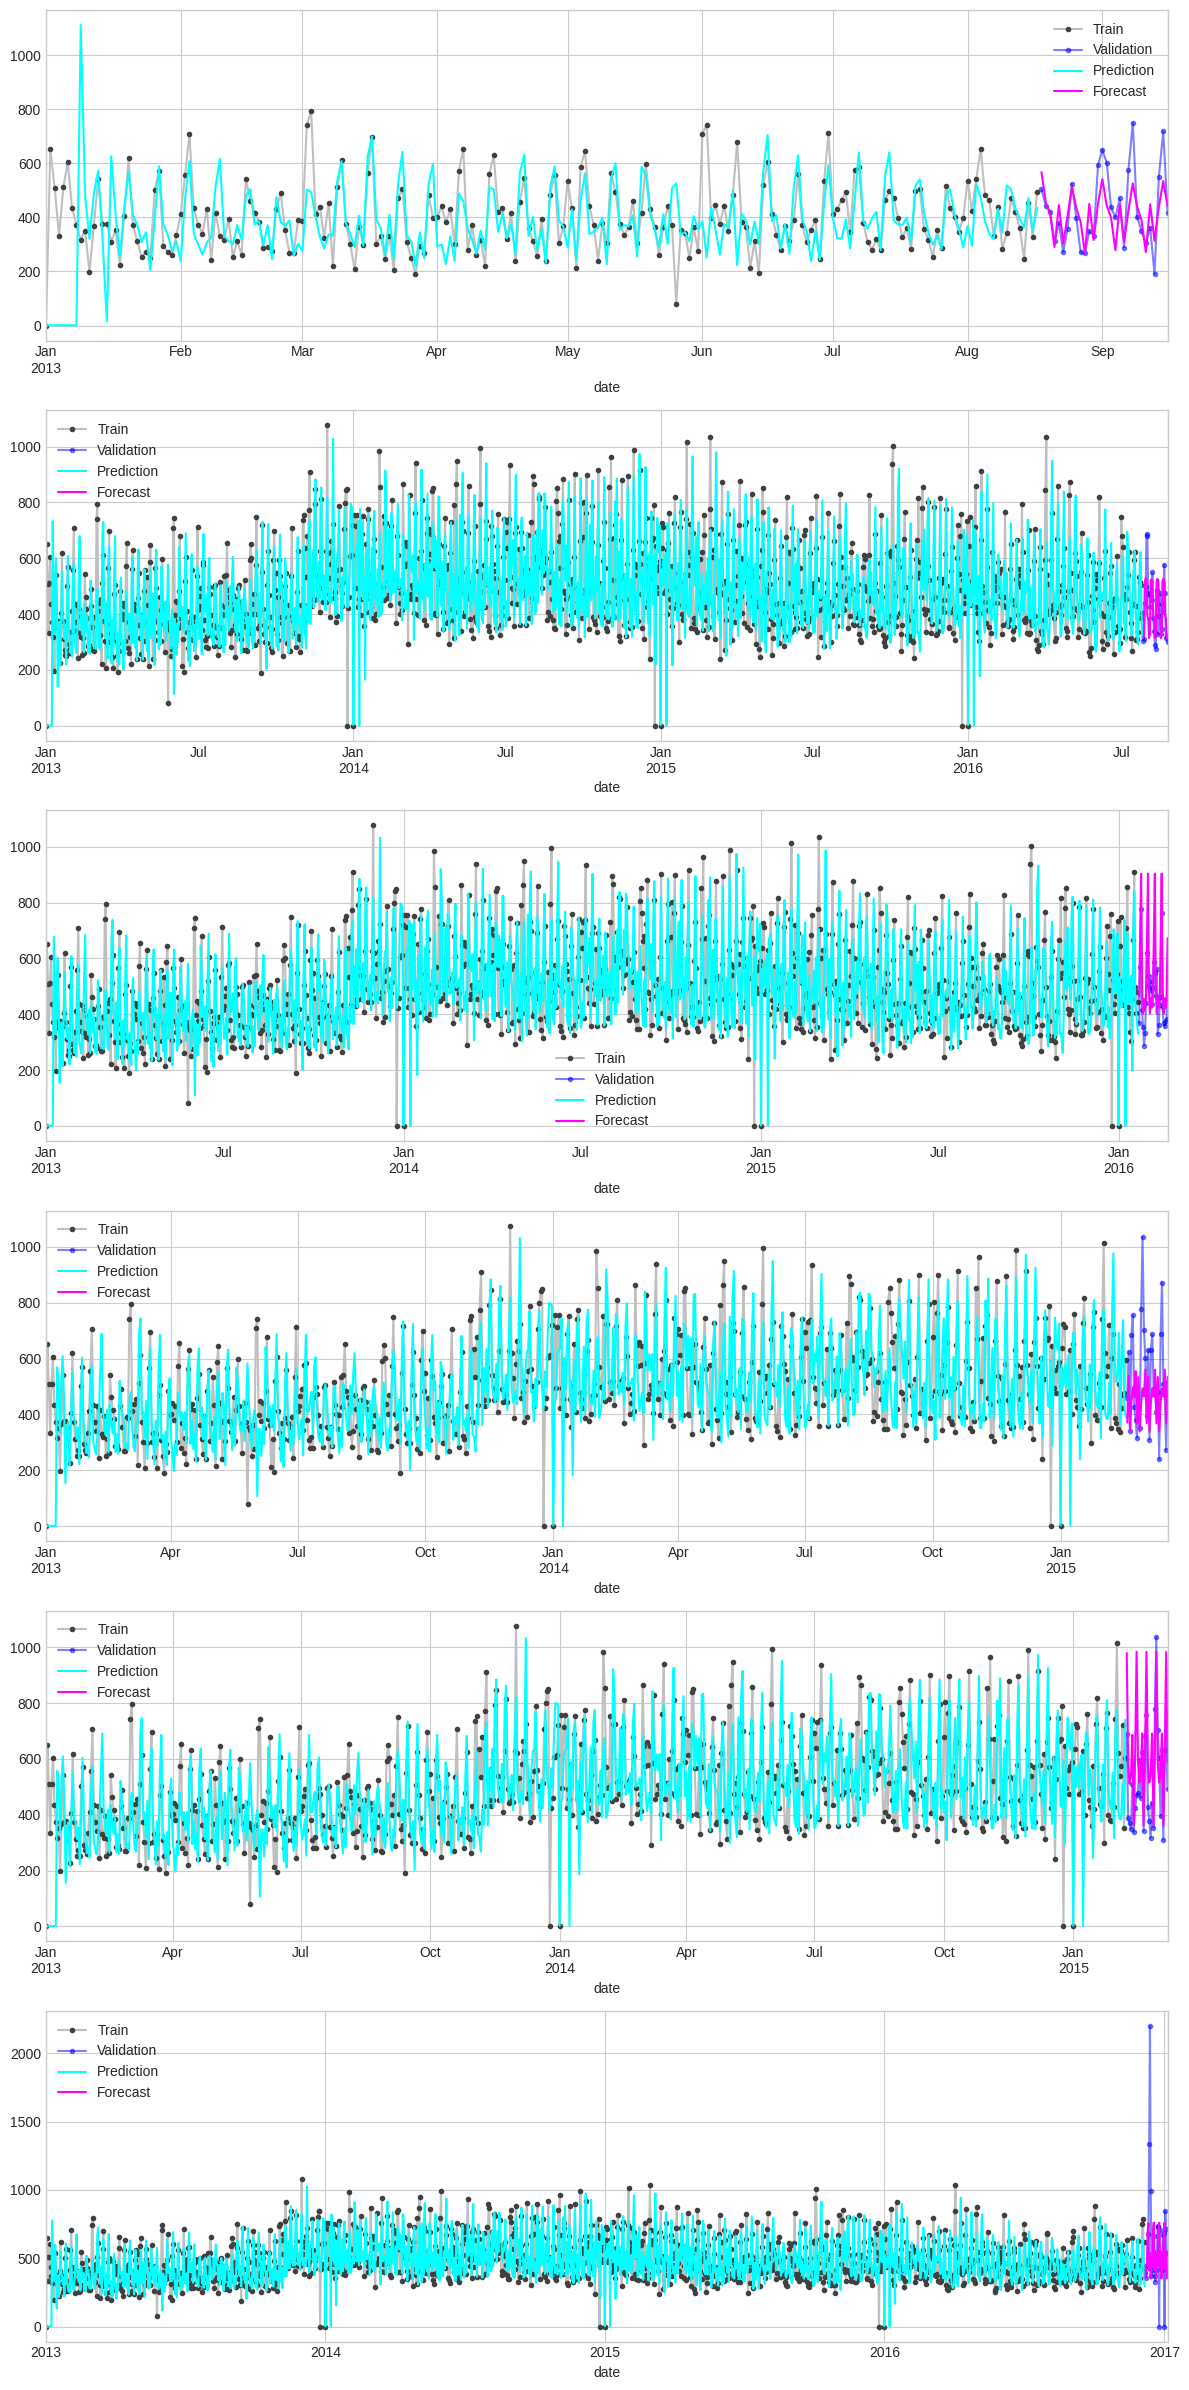

In [46]:
cross_validation_sarima(
    y, order=(1, 0, 0), seasonal_order=(1, 1, 0, 7), trend=None, plot=True
)

In [37]:
import statsmodels.tsa.api as tsa

y = store_level_sales[2]["SEAFOOD"]
y_train = y.iloc[:-30]
y_test = y.iloc[-30:]
sarima = tsa.statespace.SARIMAX(
    log_transform(y_train),
    order=(1, 0, 0),
    seasonal_order=(1, 1, 0, 7),
    trend=None,
).fit()
y_pred = inverse_log_transform(model.predict())
y_fore = inverse_log_transform(
    model.predict(start=y_test.index[0], end=y_test.index[-1])
)

ax = y.plot(**plot_params)
y_pred.plot(ax=ax, color="cyan")
y_fore.plot(ax=ax, color="red")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.51066D-01    |proj g|=  1.81847D-01

At iterate    5    f=  5.49371D-01    |proj g|=  5.01151D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   8.566D-06   5.494D-01
  F =  0.54936810272635572     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


NameError: name 'model' is not defined

In [ ]:
mean_absolute_error(y_train, y_pred), mean_squared_error(
    y_train, y_pred
), mean_absolute_percentage_error(y_train, y_pred)

In [ ]:
mean_absolute_error(y_test, y_fore), mean_squared_error(
    y_test, y_fore
), mean_absolute_percentage_error(y_test, y_fore)

In [ ]:
y_train[y_train == 0] = 0.5
np.abs((y_train - y_pred.shift(-7)) / y_train).mean(), y_train, y_pred

In [ ]:
import statsmodels.tsa.api as tsa

tsa.statespace.SARIMAX.predict?